In [39]:
%set_env CUDA_VISIBLE_DEVICES=1

import os

os.chdir(
    "/project/nanocourse/SWE_OOP/train07/Module_2_VMullapudi/04_ExerciseCodeAndInstructions/imageio"
)
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import itertools
import tensorflow as tf
import tensorflow.keras
import MyImageClass as myimg
import copy
from typing import Literal

PATH_TO_DATA = "../../06_DataFiles/oop_data/"


env: CUDA_VISIBLE_DEVICES=1


## 1. Numpy
Numpy is an extreemly commonly used python package. Its used to work with arrays.

In [40]:
arrA = np.array([[1, 3], [5, 7]])
arrB = np.array([[10, 9], [8, 7]])


In [41]:
arrA + arrB


array([[11, 12],
       [13, 14]])

In [42]:
arrA * arrB


array([[10, 27],
       [40, 49]])

## 2. Example from lecture
### 2.1 Color excel image
Let's Take a look at an image, and how images are saved as numbers
Code here, but show in excel!

In [43]:
import PIL
from PIL import Image
import skimage
import skimage.transform


In [ ]:
def fGetColor(val: int, strColor: Literal["r", "g", "b"]) -> str:
    """
    Given a value and a color, return the hex code for the color
    e.g. val=255, strColor='r' will return #ff0000
    This is designed for a single colors only
    """
    assert strColor in ["r", "g", "b"]
    assert 0 <= val <= 255, "val must be between 0 and 255"
    dctRGB = {"r": 0, "g": 0, "b": 0}
    dctRGB[strColor] = int(val)
    return fRGBToHex(**dctRGB)


def fRGBToHex(r: int, g: int, b: int) -> str:
    """
    inputs r,g,b values 0-255 and outputs the hex color string
    """
    assert 0 <= r <= 255 and 0 <= g <= 255 and 0 <= b <= 255
    return "#%02x%02x%02x" % (r, g, b)


def fColorRows(row: pd.Series) -> list:
    """
    given a row from the pandas dataframe, uses the index to determine the color channel
    return a list of styling for that row.
    """
    strColorChannel = row.name[0][1]
    lColors = [fGetColor(x, strColorChannel) for x in row]
    return ["background-color: {}".format(color) for color in lColors]


In [45]:
# load the image
img = np.array(Image.open(PATH_TO_DATA + "SNs.jpg")).astype(int)
# down sample (just to make the data size more manageable)
img = np.round(skimage.transform.rescale(img / 255, 0.5, channel_axis=2) * 255)
# split the channels for manipulation and coloration
imgR = img[:, :, 0]
imgG = img[:, :, 1]
imgB = img[:, :, 2]
# create pandas dataframes for each channel
dfR = pd.DataFrame(imgR).astype(int)
dfG = pd.DataFrame(imgG).astype(int)
dfB = pd.DataFrame(imgB).astype(int)

# Modify the index to hold the color channel name
dfR.index = pd.MultiIndex.from_product([["1r"], dfR.index])
dfG.index = pd.MultiIndex.from_product([["2g"], dfG.index])
dfB.index = pd.MultiIndex.from_product([["3b"], dfB.index])
# combine the channles into one dataframe
dfConcat = pd.concat([dfR, dfG, dfB])
dfConcat = dfConcat.map(lambda x: str(x).zfill(3))
# dfConcat.applymap(highlight_cells)


In [46]:
# output the image (without coloring the cells)
dfConcat.sort_index(level=1).to_excel(
    "../OOP/oop_outputs/SNc_numbers.xlsx", index=False, header=False
)
# output the image (color the cells)
dfConcat.sort_index(level=1).style.apply(fColorRows, axis=1).to_excel(
    "../OOP/oop_outputs/SNc_colored.xlsx", index=False, header=False
)


### 2.2 Difference image

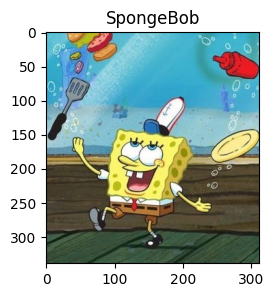

In [47]:
# simple example of how to use matplotlib
img1 = np.array(Image.open(PATH_TO_DATA + "SpongBobComp1.jpeg")).astype(int)
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
_ = ax.set_title("SpongeBob")
_ = ax.imshow(img1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0..56169].


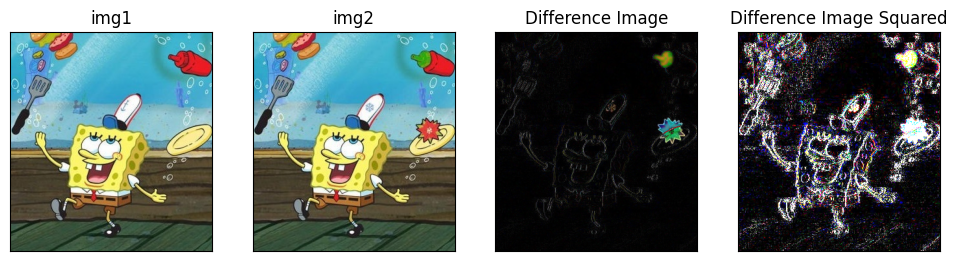

In [48]:
# load the 2 images
img1 = np.array(Image.open(PATH_TO_DATA + "SpongBobComp1.jpeg")).astype(int)
img2 = np.array(Image.open(PATH_TO_DATA + "SpongBobComp2.jpeg")).astype(int)

# create a plot
fig, axs = plt.subplots(1, 4, figsize=(12, 3))

# plot img1
axs[0].set_title("img1")
axs[0].imshow(img1)
# plot img2
axs[1].set_title("img2")
axs[1].imshow(img2)

# calc img subtraction and plot
imgDif = abs(img1 - img2)
axs[2].set_title("Difference Image")
axs[2].imshow(imgDif)

# calc square of dif and plot
imgDif2 = (img1 - img2) ** 2
axs[3].set_title("Difference Image Squared")
axs[3].imshow(imgDif2)

for ax in axs:
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])


## 3. Image analysis on MNIST

In [49]:
# Run this cell if you update the MyImageClass.py file
# This allows you to reload the MyImageClass script so you don't have to restart the kernel
# if you change the code. But don't forget to remake the objects with the updated class!

import importlib

importlib.reload(myimg)


<module 'MyImageClass' from '/project/nanocourse/SWE_OOP/train07/Module_2_VMullapudi/04_ExerciseCodeAndInstructions/imageio/MyImageClass.py'>

### 3.1 Load the MNIST dataset

In [50]:
_, (arrImg, arrTarget) = tensorflow.keras.datasets.mnist.load_data()
arrImg = arrImg / 255
intNTargets = arrTarget.max()


### 3.2 create ImgArray objects from the MNIST dataset (one per image)

In [51]:
# create lists of the image target from the data
lImg = [
    myimg.MyImgClass(arrImg, intTarget) for arrImg, intTarget in zip(arrImg, arrTarget)
]
# create a dict that contains a list of each image class
dctImgTarget = {}  # update to label
for i in range(intNTargets + 1):
    dctImgTarget[i] = [x for x in lImg if x.intLabel == i]


### 3.3 visualize an example of each digit

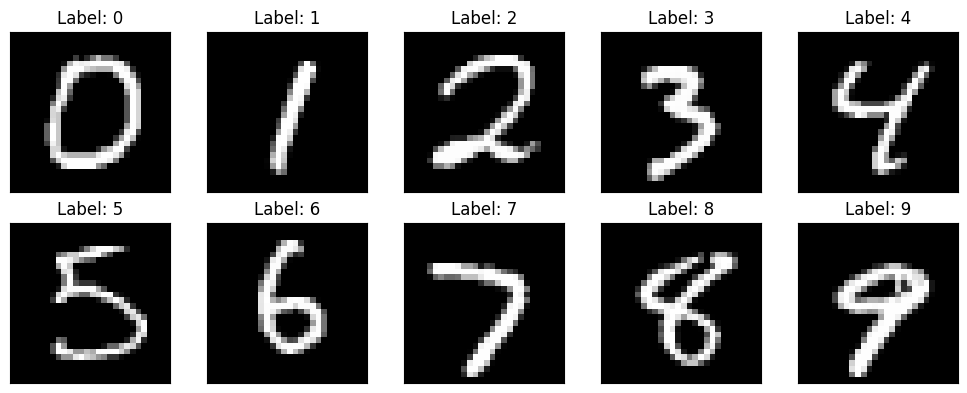

In [52]:
# plot the first of each digits
fig, axs = plt.subplots(2, 5, figsize=(10, 4))
axs = axs.flatten()
for i in range(intNTargets + 1):
    dctImgTarget[i][1].fPlot(axs[i], imshow_kwargs={"cmap": "gray"})
plt.tight_layout()


### 3.4 Create mean and std iamges across all images

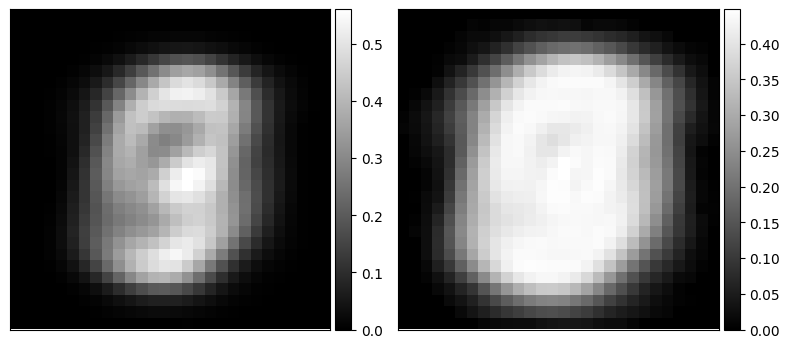

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
imgAve = myimg.MyImgClass.fComputeMeanAcrossImages(lImg)
imgStd = myimg.MyImgClass.fComputeStdAcrossImages(lImg)

imgAve.fPlot(axs[0], imshow_kwargs={"cmap": "gray"}, add_colorbar=True)
imgStd.fPlot(axs[1], imshow_kwargs={"cmap": "gray"}, add_colorbar=True)
plt.tight_layout()


### 3.5 Create mean and std images for each class

In [54]:
# create the average image for each class
dctAvgImg = {}
dctStdImg = {}
for i in range(intNTargets + 1):
    dctAvgImg[i] = myimg.MyImgClass.fComputeMeanAcrossImages(dctImgTarget[i])
    dctStdImg[i] = myimg.MyImgClass.fComputeStdAcrossImages(dctImgTarget[i])


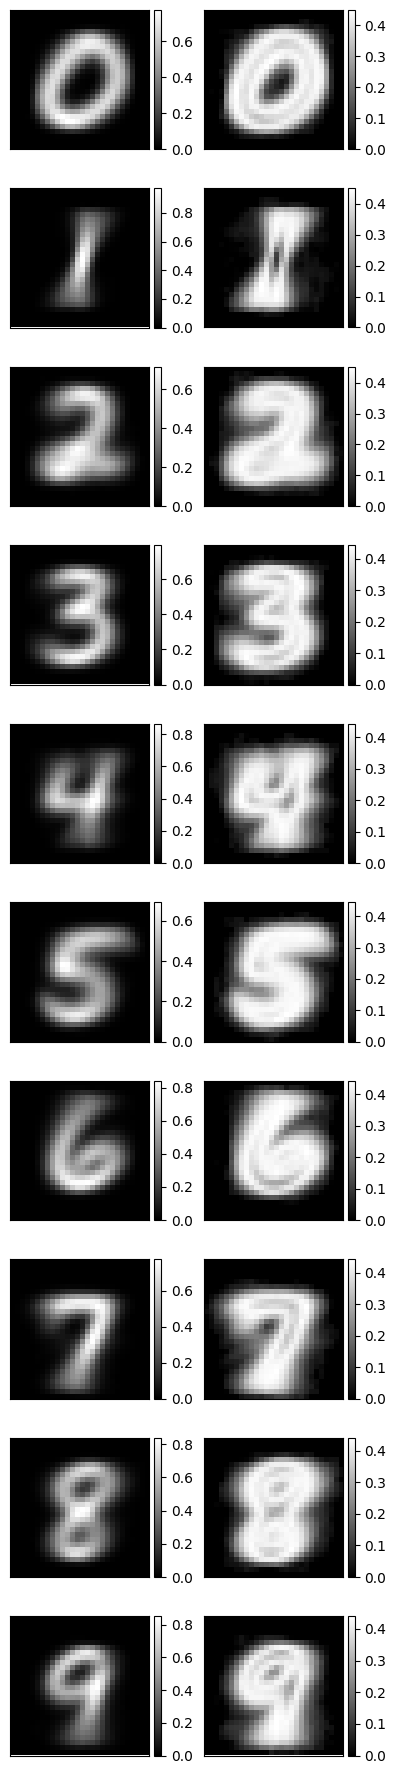

In [55]:
# plot the average for each image
fig, axs = plt.subplots(intNTargets + 1, 2, figsize=(4, 2 * intNTargets))
for intTarget in dctAvgImg.keys():
    dctAvgImg[intTarget].fPlot(
        axs[intTarget, 0], imshow_kwargs={"cmap": "gray"}, add_colorbar=True
    )
    dctStdImg[intTarget].fPlot(
        axs[intTarget, 1], imshow_kwargs={"cmap": "gray"}, add_colorbar=True
    )
fig.tight_layout()


### 3.6 Difference images and Mean squared error (MSE)
### 3.6.1 difference images and MSE between numbers

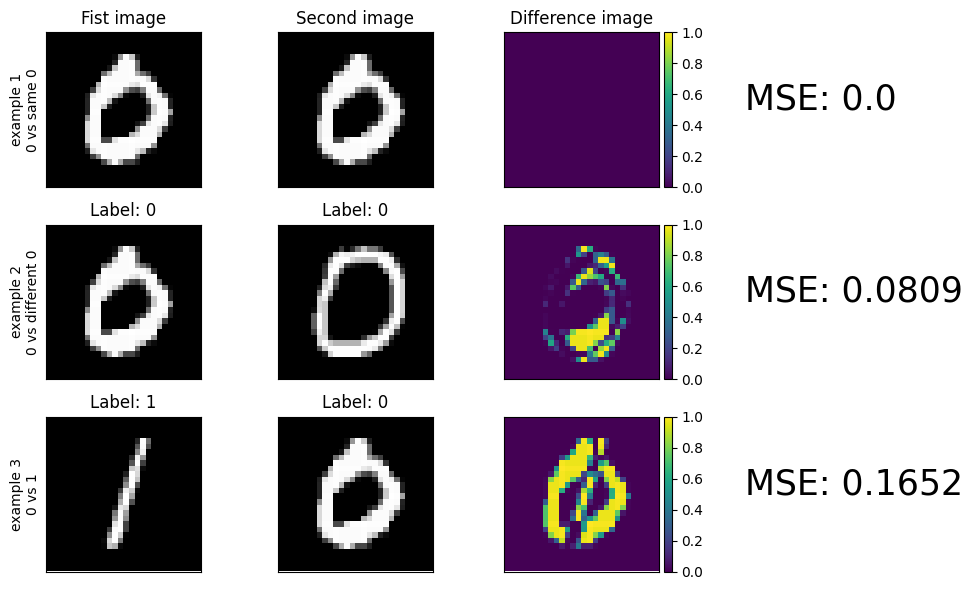

In [ ]:
fig, axs = plt.subplots(3, 4, figsize=(10, 6))

### Calc and plot 0 vs same 0 ###
# what is the type of imgDifSame?!
imgDifSame0v0: myimg.MyImgClass = dctImgTarget[0][0].fPixelwiseSqDif(dctImgTarget[0][0])
dMSESame0v0: np.floating = dctImgTarget[0][0].fMSE(dctImgTarget[0][0])
# plot
dctImgTarget[0][0].fPlot(
    axs[0, 0], imshow_kwargs={"cmap": "gray", "vmin": 0, "vmax": 1}
)
dctImgTarget[0][0].fPlot(
    axs[0, 1], imshow_kwargs={"cmap": "gray", "vmin": 0, "vmax": 1}
)
imgDifSame0v0.fPlot(
    axs[0, 2],
    imshow_kwargs={"cmap": "viridis", "vmin": 0, "vmax": 1},
    add_colorbar=True,
)
axs[0, 3].axis("off")
axs[0, 3].text(x=0.1, y=0.5, s=f"MSE: {round(dMSESame0v0, 4)}", fontsize=25)


### Clac and plot 0 vs different 0 ###
imgDif0v0: myimg.MyImgClass = dctImgTarget[0][0].fPixelwiseSqDif(dctImgTarget[0][2])
dMSE0v0: np.floating = dctImgTarget[0][0].fMSE(dctImgTarget[0][2])
# plot
dctImgTarget[0][0].fPlot(
    axs[1, 0], imshow_kwargs={"cmap": "gray", "vmin": 0, "vmax": 1}
)
dctImgTarget[0][1].fPlot(
    axs[1, 1], imshow_kwargs={"cmap": "gray", "vmin": 0, "vmax": 1}
)
imgDif0v0.fPlot(
    axs[1, 2],
    imshow_kwargs={"cmap": "viridis", "vmin": 0, "vmax": 1},
    add_colorbar=True,
)
axs[1, 3].axis("off")
axs[1, 3].text(x=0.1, y=0.5, s=f"MSE: {round(dMSE0v0, 4)}", fontsize=25)

### Clac and plot 0 vs different 0 ###
imgDif1v0: myimg.MyImgClass = dctImgTarget[1][0].fPixelwiseSqDif(dctImgTarget[0][0])
dMSE1v0: np.floating = dctImgTarget[1][0].fMSE(dctImgTarget[0][0])
# plot
dctImgTarget[1][0].fPlot(
    axs[2, 0], imshow_kwargs={"cmap": "gray", "vmin": 0, "vmax": 1}
)
dctImgTarget[0][0].fPlot(
    axs[2, 1], imshow_kwargs={"cmap": "gray", "vmin": 0, "vmax": 1}
)
imgDif1v0.fPlot(
    axs[2, 2],
    imshow_kwargs={"cmap": "viridis", "vmin": 0, "vmax": 1},
    add_colorbar=True,
)
axs[2, 3].axis("off")
axs[2, 3].text(x=0.1, y=0.5, s=f"MSE: {round(dMSE1v0, 4)}", fontsize=25)

axs[0, 0].set_title("Fist image")
axs[0, 1].set_title("Second image")
axs[0, 2].set_title("Difference image")

axs[0, 0].set_ylabel("example 1\n0 vs same 0")
axs[1, 0].set_ylabel("example 2\n0 vs different 0")
axs[2, 0].set_ylabel("example 3\n0 vs 1")

plt.tight_layout()


###  3.6.2 calcualte the difference between the mean images

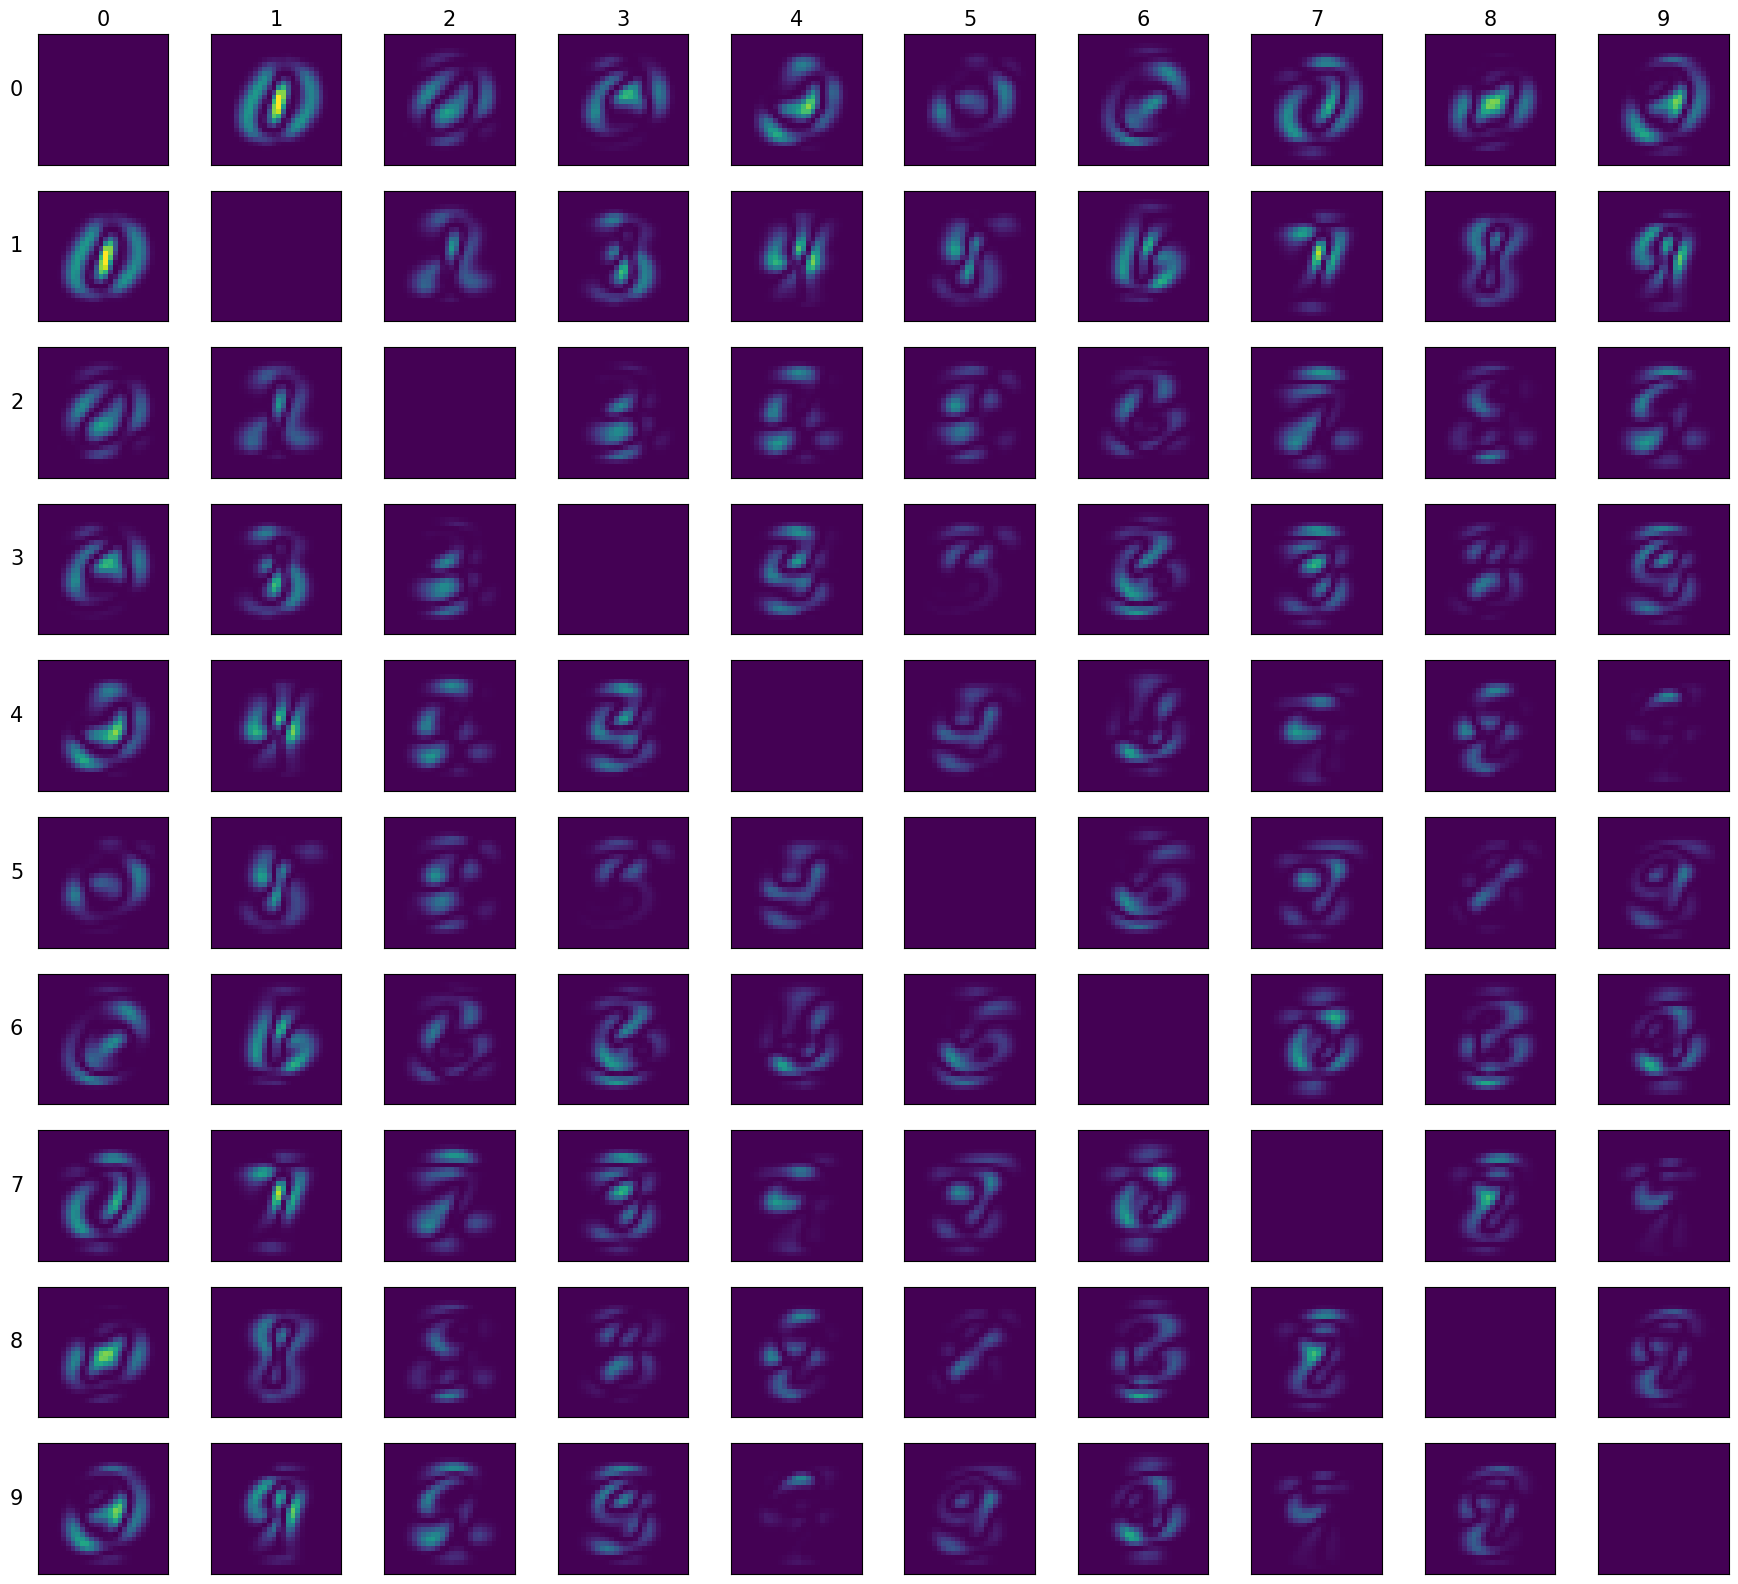

In [ ]:
fig, axs = plt.subplots(10, 10, figsize=(22, 20))
for i in range(10):
    axs[0, i].set_title(i, fontsize=15)
    axs[i, 0].set_ylabel(i, rotation=0, fontsize=15, labelpad=15)
    for j in range(10):
        imgDif: myimg.MyImgClass = dctAvgImg[i].fPixelwiseSqDif(dctAvgImg[j])
        # print(imgDif.arrImg.max())
        imgDif.fPlot(
            axs[i, j],
            imshow_kwargs={"cmap": "viridis", "vmin": 0, "vmax": 0.85},
            show_ticks=False,
        )


### 3.6.3 claculate the MSE between the mean images. 
Note: This is a summary of the above plot where each plot is a sinlge value (mean)!
Rather than plot an image, here we create a heatmap to visually display the differences between the mean digit images per class

In [58]:
# create a numpy array with the MSE between the mean numbers
arrMSE = np.empty(shape=(10, 10))
for i in range(10):
    for j in range(10):
        arrMSE[i, j] = dctAvgImg[i].fMSE(dctAvgImg[j])


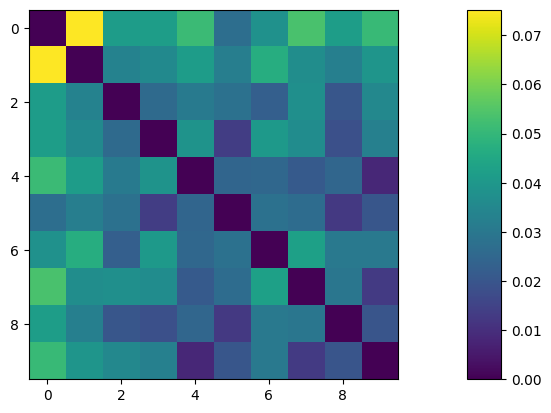

In [59]:
# plot as heatmap.
fig, axs = plt.subplots(1, 2, gridspec_kw={"width_ratios": [12, 1]})
hm = axs[0].imshow(arrMSE)
fig.colorbar(hm, axs[1])


# 4. Can you use the class to compare MRI images?!
One common phenotype of Alzheimer's disease is atrophy of the brain. 

### 4.1 Load the data

In [60]:
# use 32x32 small examples
dctT1 = np.load(PATH_TO_DATA + "T1_slice.npz")
arrImgLarge = dctT1["images"][:, :, :, 0]
# we're working with 32 by 32 for this course so let's downsample
arrImg = np.stack(
    [skimage.transform.rescale(arr, 1 / 6, anti_aliasing=False) for arr in arrImgLarge]
)
arrTarget = dctT1["label"]


### 4.2 organlize the data

In [61]:
lT1Img = [
    myimg.MyImgClass(arrImg, intLabel) for arrImg, intLabel in zip(arrImg, arrTarget)
]
lT1ImgLarge = [
    myimg.MyImgClass(arrImg, intLabel)
    for arrImg, intLabel in zip(arrImgLarge, arrTarget)
]
lT1ImgCN = [img for img in lT1Img if img.intLabel == 0]
lT1ImgAD = [img for img in lT1Img if img.intLabel == 1]


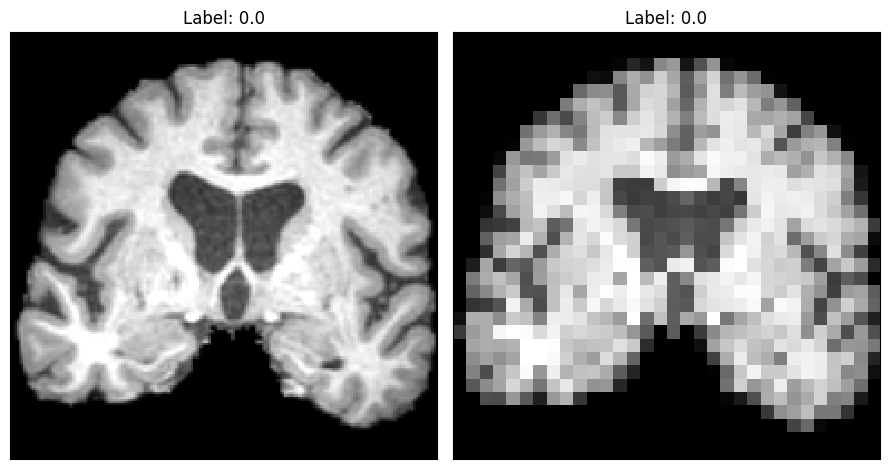

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(9, 8))
lT1ImgLarge[35].fPlot(ax=axs[0], imshow_kwargs={"cmap": "gray"})
lT1Img[35].fPlot(ax=axs[1], imshow_kwargs={"cmap": "gray"})
plt.tight_layout()


### 4.3 Plot example images of the data

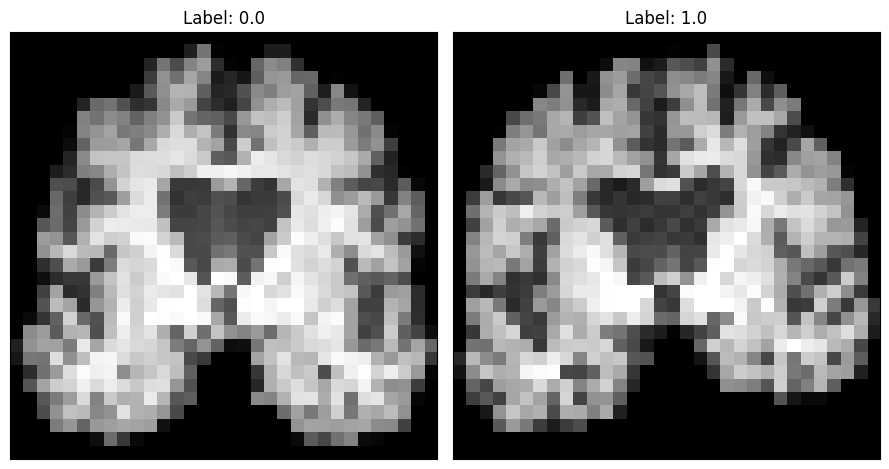

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(9, 8))
lT1ImgCN[3].fPlot(ax=axs[0], imshow_kwargs={"cmap": "gray"})
lT1ImgAD[40].fPlot(ax=axs[1], imshow_kwargs={"cmap": "gray"})
plt.tight_layout()


## 4.4 Calculate and plot the mean and std images

In [64]:
imgCNAve = myimg.MyImgClass.fComputeMeanAcrossImages(lT1ImgCN)
imgCNStd = myimg.MyImgClass.fComputeStdAcrossImages(lT1ImgCN)
imgADAve = myimg.MyImgClass.fComputeMeanAcrossImages(lT1ImgAD)
imgADStd = myimg.MyImgClass.fComputeStdAcrossImages(lT1ImgAD)


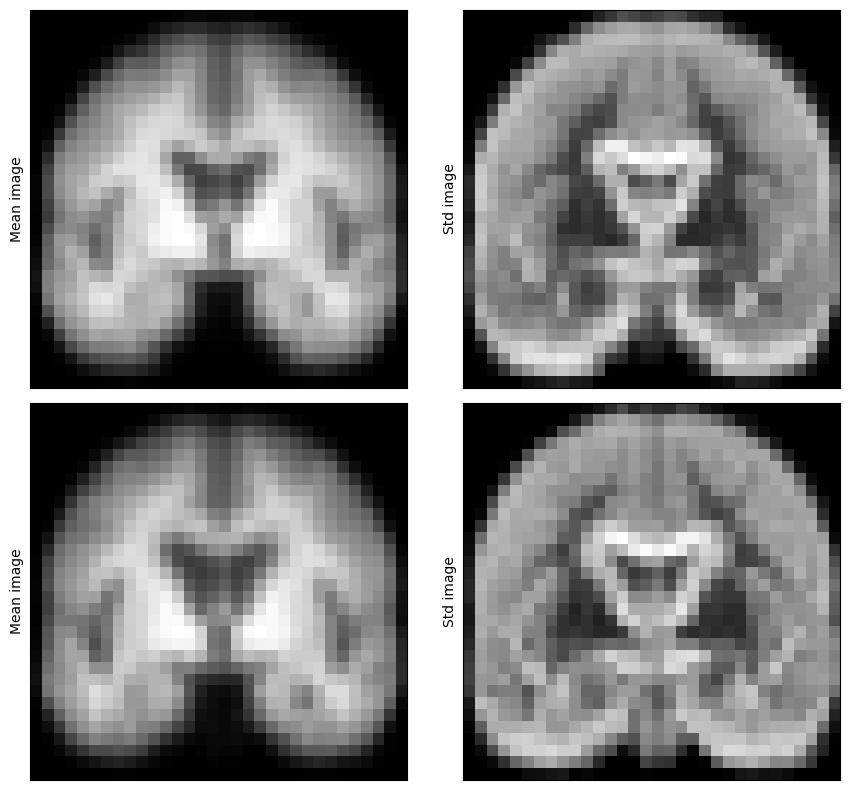

In [65]:
fig, axs = plt.subplots(2, 2, figsize=(9, 8))
imgCNAve.fPlot(axs[0, 0], imshow_kwargs={"cmap": "gray"})
imgCNStd.fPlot(axs[0, 1], imshow_kwargs={"cmap": "gray"})
imgADAve.fPlot(axs[1, 0], imshow_kwargs={"cmap": "gray"})
imgADStd.fPlot(axs[1, 1], imshow_kwargs={"cmap": "gray"})
axs[0][0].set_ylabel("Mean image")
axs[1][0].set_ylabel("Mean image")
axs[0][1].set_ylabel("Std image")
axs[1][1].set_ylabel("Std image")
plt.tight_layout()


## 4.5 Calcualte and plot the difference image from the two averages

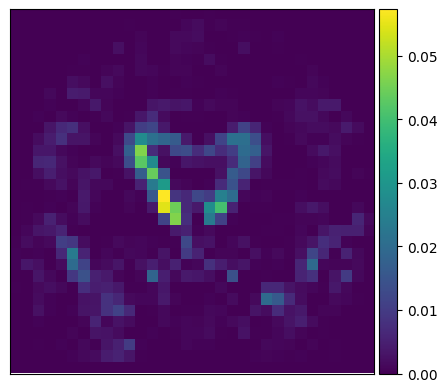

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
arrImgDifOfAve = imgCNAve.fPixelwiseSqDif(imgADAve)
arrImgDifOfAve.fPlot(ax, add_colorbar=True)


## 4.6 Calcaulate and plot pairwise differences an plot

In [67]:
import MyImageClass
import importlib

importlib.reload(MyImageClass)


<module 'MyImageClass' from '/project/nanocourse/SWE_OOP/train07/Module_2_VMullapudi/04_ExerciseCodeAndInstructions/imageio/MyImageClass.py'>

In [68]:
# this is pair wise difference, so take ~10 secs
lMSDCvC = myimg.MyImgClass.fMSEforEachPairCombination(lT1ImgCN, lT1ImgCN)
lMSDCvA = myimg.MyImgClass.fMSEforEachPairCombination(lT1ImgCN, lT1ImgAD)
lMSDAvA = myimg.MyImgClass.fMSEforEachPairCombination(lT1ImgAD, lT1ImgAD)


In [69]:
dfMeanPixelwiseSqDif = pd.DataFrame(
    [lMSDCvC, lMSDCvA, lMSDAvA], index=["CN vs CN", "CN vs AD", "AD vs AD"]
).T


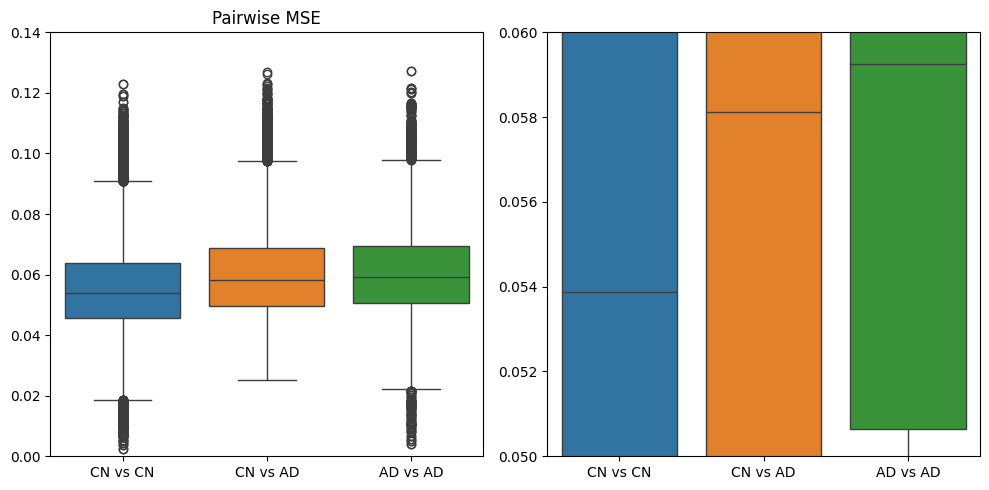

In [70]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
_ = sns.boxplot(data=dfMeanPixelwiseSqDif, ax=axs[0])
_ = sns.boxplot(data=dfMeanPixelwiseSqDif, ax=axs[1])
# _ = sns.swarmplot(data=dfMeanPixelwiseSqDif, ax=axs[0], color='k')#this takes too long to plot
axs[0].set_title("Pairwise MSE")
axs[0].set_ylim(0, 0.14)
axs[1].set_ylim(0.05, 0.06)
plt.tight_layout()


In [71]:
imgADAve.arrImg.shape


(32, 32)

## 5. Use MSE to compare between reconstructed images 
* (teaser on auto encoders)
    * An autoencoder attempts to recreate the input.
* Check our MSE to keras

### 5.1 Plot the original and the recon images at different epochs

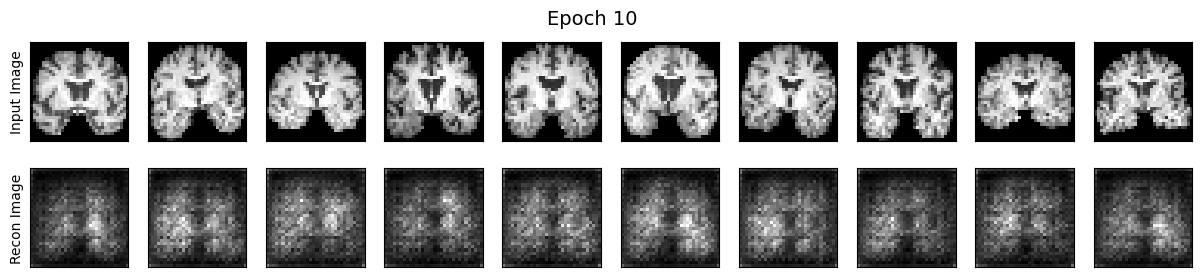

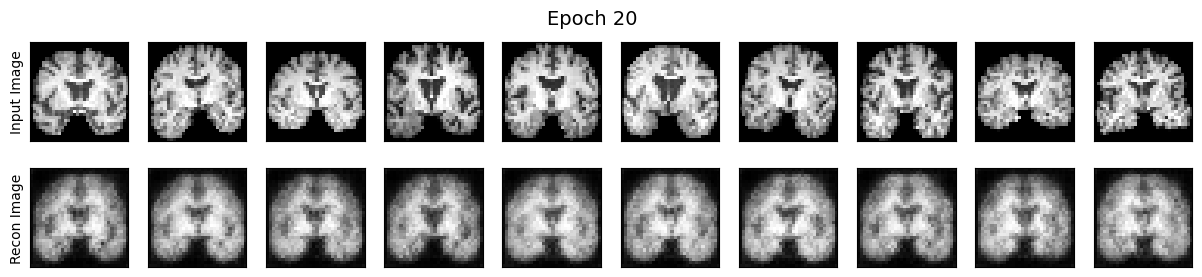

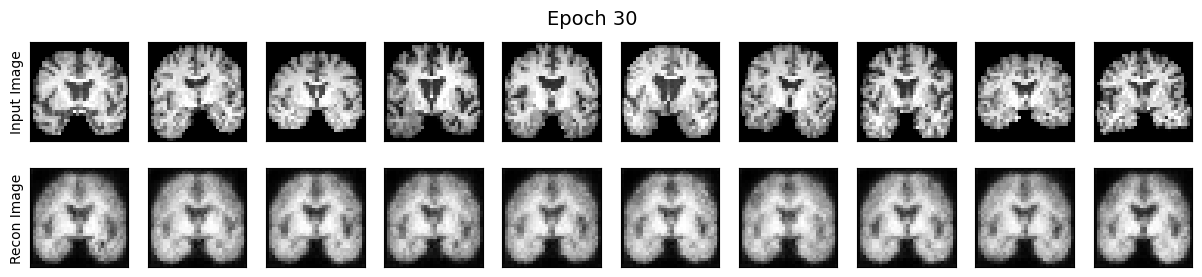

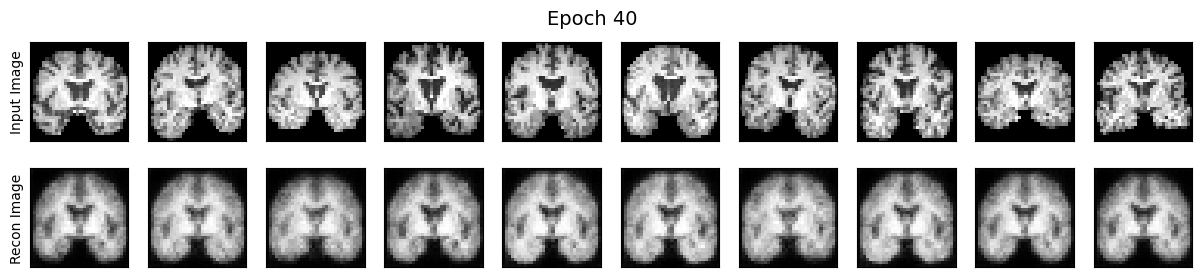

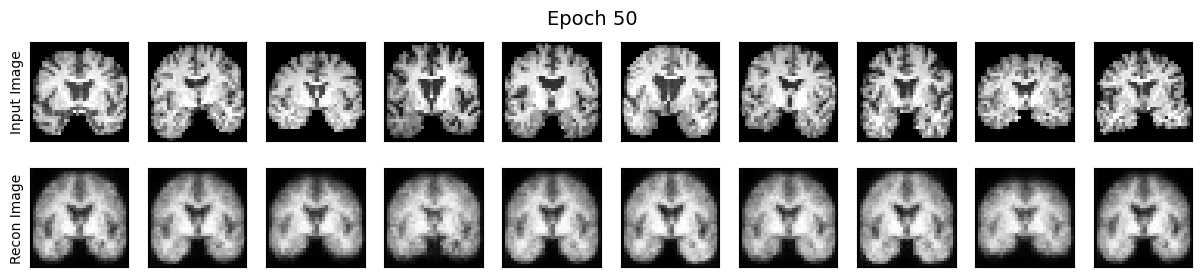

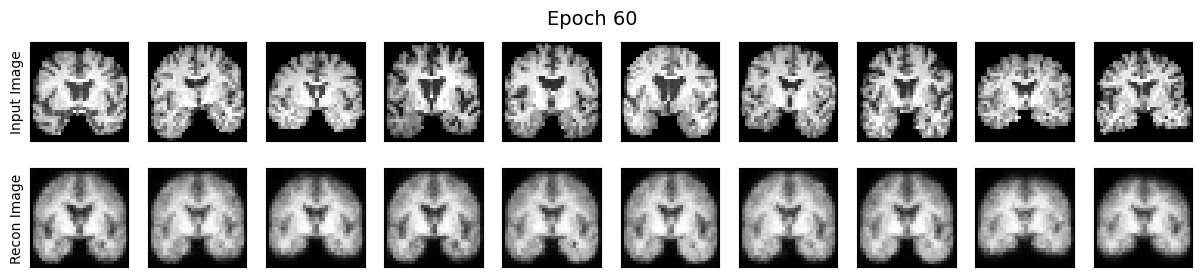

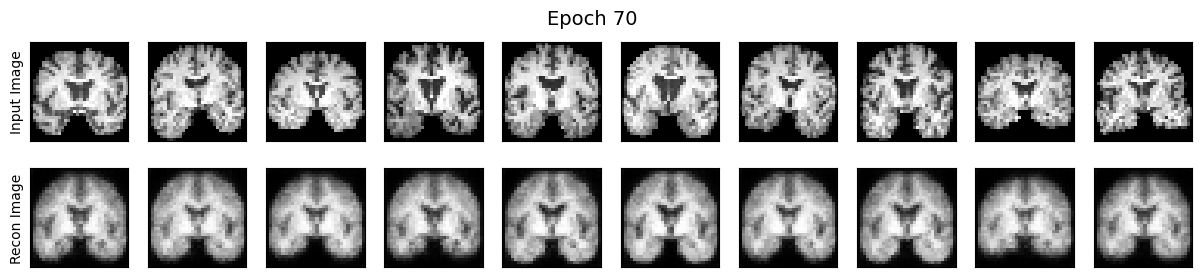

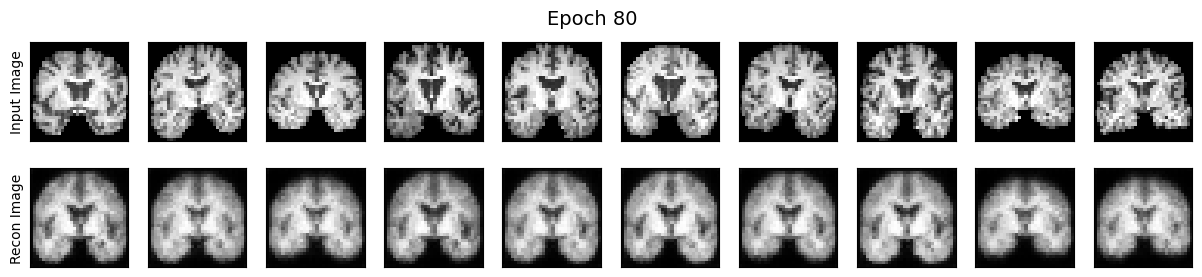

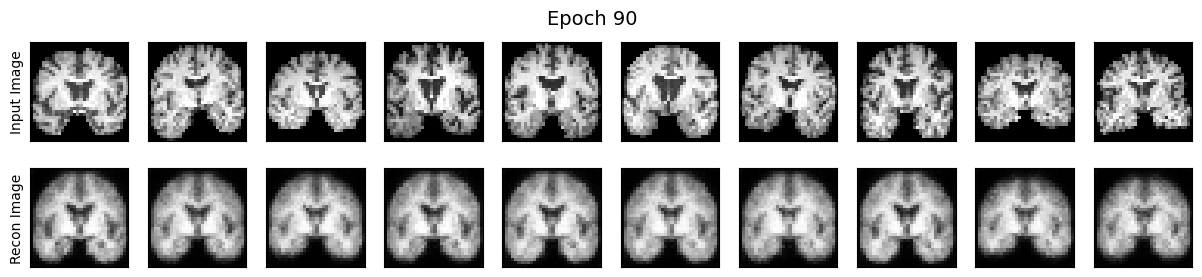

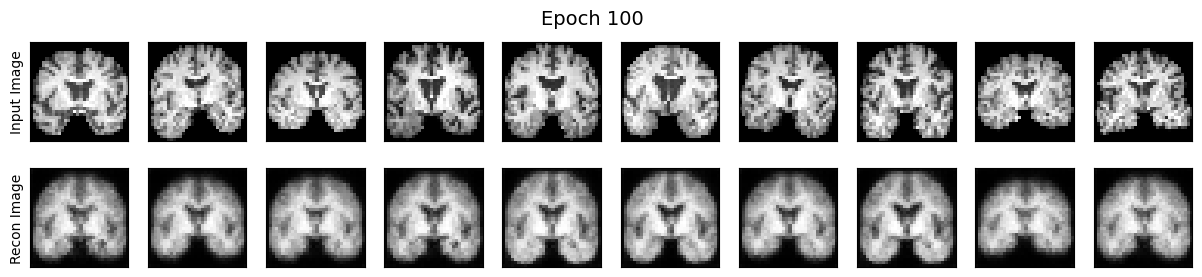

In [72]:
dfLoss = pd.Series(index=range(1, 101))

for intEpoch in range(1, 101):
    arrReal = np.load(
        PATH_TO_DATA + f"ad_cvaecgan_simloss/epoch{str(intEpoch).zfill(3)}_real.npy"
    )[:, :, :, 0]
    arrRecon = np.load(
        PATH_TO_DATA + f"ad_cvaecgan_simloss/epoch{str(intEpoch).zfill(3)}_recons.npy"
    )[:, :, :, 0]
    lImgReal = [myimg.MyImgClass(x) for x in arrReal]
    lImgRecon = [myimg.MyImgClass(x) for x in arrRecon]

    # loss
    lLoss = []
    for imgReal, imgRecon in zip(lImgReal, lImgRecon):
        lLoss.append(imgReal.fMSE(imgRecon))
    # keras takes the mean MSE across images to provide a single loss value, we'll do the same for comparison
    dCalcLoss = np.mean(lLoss)
    dfLoss.loc[intEpoch] = dCalcLoss

    if intEpoch % 10 == 0:
        fig, axs = plt.subplots(2, 10, figsize=(15, 3))
        for i in range(lImgReal.__len__()):
            lImgReal[i].fPlot(axs[0, i], imshow_kwargs={"cmap": "gray"})
            lImgRecon[i].fPlot(axs[1, i], imshow_kwargs={"cmap": "gray"})
        _ = axs[0, 0].set_ylabel("Input Image")
        _ = axs[1, 0].set_ylabel("Recon Image")
        plt.suptitle(f"Epoch {intEpoch}", fontsize=14)

        plt.show()


### 5.2 plot the loss per epoch

Text(0.5, 0, 'Epoch')

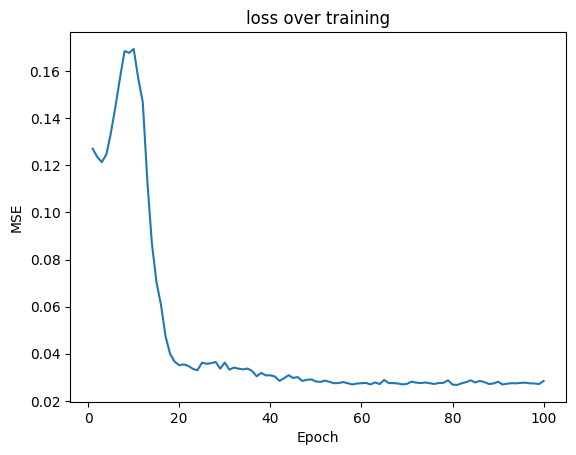

In [73]:
fig, ax = plt.subplots(1, 1)
sns.lineplot(data=dfLoss, ax=ax)
ax.set_title("loss over training")
ax.set_ylabel("MSE")
ax.set_xlabel("Epoch")


### 5.3 Calculate the MSE for the last epoch and compare to the tf.keras function.

In [74]:
# calcualte the mean MSE
dCalcLoss = myimg.MyImgClass.fMeanMSE(lImgReal, lImgRecon)
print(f"MSE: {str(dCalcLoss)[:8]}")


MSE: 0.028410


In [75]:
# calc the MSE using TF/keras
dKerasLoss = tf.keras.losses.MeanSquaredError()(arrReal, arrRecon).numpy()
print(f"keras MSE: {str(dKerasLoss)[:8]}")


keras MSE: 0.028410


In [76]:
# make sure the difference is very small (e.g <1e-6)
dCalcLoss - dKerasLoss


np.float32(0.0)